# Introduction

With the advance of deep learning, computers can now compose music using trained models based on the sample pieces. This not only allows artists that are lack of the domain knowledge to accomplish their ideas, but also provides possible creative styles and patterns that may foster the composer's creative process. 

In the project, a Recurrent Neural Network (RNN) model is built using LSTM and dense layers. The model is then trained on 10 of Frédéric Chopin's Valse and Waltz pieces in MIDI format downloaded from [*kunstderfuge.com*](http://www.kunstderfuge.com/chopin.htm). The MIDI files are converted to numeric, sequential data and fed into the RNN for training. The trained RNN reads a pattern of notes, then generates new notes based on the sequence. 

Moreover, to explore different styles of piano pieces, a dataset of 8 Nocturne pieces by Frédéric Chopin downloaded from [*8notes.com*](https://www.8notes.com/school/search_fsm.asp?keyword=chopin+nocturne&x=0&y=0&pageA=1) are used to train a complete seperate RNN model. The generated sample pieces from the Valse model and the Nocturne model can be found [here](https://drive.google.com/drive/folders/1EtkZnCGtkbKOGfVaamLZjXdWjsgXqizi?usp=sharing).  


# Data Preprocessing

Import necessary libraries and collect data files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from music21 import converter, instrument, note, chord, stream
from timidity import Parser, play_notes

import pickle
import glob

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten, Embedding
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
valseMusic = glob.glob('Nocturnes Dataset/*.mid')
valseMusic

['Nocturnes Dataset/chopin_Nocturne_b49.mid',
 'Nocturnes Dataset/chopin_op55_1.mid',
 'Nocturnes Dataset/Nocturne_Opus_72_No_1_in_E_Minor.mid',
 'Nocturnes Dataset/chopin_nocturneop9nr1.mid',
 'Nocturnes Dataset/chopin_op55_2.mid',
 'Nocturnes Dataset/chop32n2.mid',
 'Nocturnes Dataset/chopin_nocturne_9_2.mid',
 'Nocturnes Dataset/chopin_cminor_nocturne_b108_PNO.mid']

Using the *music21* library, the MIDI files are first parsed into single instrument track of notes and chords, then chords are further broken down into groups of notes. The MIDI files are concatenated and are eventually converted to a sequence of notes.

In [3]:
processedNotes = []

for valse in valseMusic:
    
    # parse Midi
    valse = converter.parse(valse)
    
    # Handle cases for multi-instruments
    try:
        parts = instrument.partitionByInstrument(valse)
        notes = parts.parts[0].recurse()
    except:
        notes = valse.flat.notes
    
    # Handle chords
    for singleNote in notes:
        if isinstance(singleNote, chord.Chord):
            processedNotes.append('.'.join(str(norm) for norm in singleNote.normalOrder))
        elif isinstance(singleNote, note.Note):
            processedNotes.append(str(singleNote.pitch))

# Save a notes library
with open('nocturnesNotesLibrary', 'wb') as file:
    pickle.dump(processedNotes, file)

Furthermore, each unique note/pitch is assigned with a unique number. The sequence of notes is then divided into subsequences, each containing the numeric representation of 100 notes. The training data that is fed into the network is then sequences of 100 numbers, each representing a corresponding note. The label/output of each input sequence is the next note that is after the 100-note sequence, also represented by a number.

In [4]:
SEQSIZE = 100

alphabetSize = len(set(processedNotes))

# Find unique pitches
pitches = sorted(set(processedNote for processedNote in processedNotes))

# a dict to convert each unique note to a unique number.
dictRef = dict((pitch, num) for num, pitch in enumerate(pitches))

inputNotes = []
outputNotes = []

# Divide sequence into subsequences of 100 notes, then convert notes to numbers
for i in range(0, len(processedNotes) - SEQSIZE):
    batchInput = processedNotes[i: i+SEQSIZE]
    batchOutput = processedNotes[i+SEQSIZE]
    inputNotes.append([dictRef[n] for n in batchInput])
    outputNotes.append([dictRef[batchOutput]])

# reshape the input and normalize, convert output to categorical.
batchNum = len(inputNotes)
inputNotes = np.reshape(inputNotes, (batchNum, SEQSIZE, 1)) / float(alphabetSize)
outputNotes = to_categorical(outputNotes)

# RNN Model Training

The design of the RNN model is traditional and is structured as follows. Two LSTM-and-Dropout groups are followed by two densely-connected layers, also accompanied by Dropout layers. The output activation function is softmax. Since this is a single-label classification task, categorical crossentropy loss is used. 

In [5]:
def createRNNModel(inputNotes, outputNum):
    
    rnnModel = Sequential([
        LSTM(128, 
             input_shape=inputNotes.shape[1:],
             return_sequences=True, 
             recurrent_initializer='glorot_uniform',
             recurrent_activation='sigmoid'), 
        Dropout(0.2),

        LSTM(128, 
             return_sequences=True,
             recurrent_initializer='glorot_uniform',
             recurrent_activation='sigmoid'), 
        Dropout(0.2),

        Flatten(),
        Dropout(0.2),
        Dense(256),
        Dropout(0.2),

        Dense(outputNum, activation='softmax')
    ])
    
    rnnModel.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return rnnModel
    
rnnModel = createRNNModel(inputNotes, alphabetSize)

To ensure the style is mapped, the model is trained with 500 epochs. It is worth mentioning that since there are such great varieties in the labels, validation and early stopping mechanisms are not used.

In [6]:
checkpointCallback = ModelCheckpoint('ChopinNocturnesLSTMx2.hdf5', monitor='loss', 
                             verbose=2, save_best_only=True)
rnnModel.fit(inputNotes, outputNotes, epochs=500, batch_size=32, callbacks=[checkpointCallback])

Epoch 1/500
7164/7164 [==============================] - 36s 5ms/step - loss: 4.4920

Epoch 00001: loss improved from inf to 4.49198, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 2/500
7164/7164 [==============================] - 33s 5ms/step - loss: 4.4054

Epoch 00002: loss improved from 4.49198 to 4.40539, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 3/500
7164/7164 [==============================] - 31s 4ms/step - loss: 4.3492

Epoch 00003: loss improved from 4.40539 to 4.34921, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 4/500
7164/7164 [==============================] - 31s 4ms/step - loss: 4.2998

Epoch 00004: loss improved from 4.34921 to 4.29977, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 5/500
7164/7164 [==============================] - 31s 4ms/step - loss: 4.2629

Epoch 00005: loss improved from 4.29977 to 4.26293, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 6/500
7164/7164 [==============================] - 32s 4ms/step - loss: 4.2074

Epoch 00006: 

7164/7164 [==============================] - 37s 5ms/step - loss: 0.2457

Epoch 00047: loss did not improve from 0.21076
Epoch 48/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.2015

Epoch 00048: loss improved from 0.21076 to 0.20150, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 49/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.1953

Epoch 00049: loss improved from 0.20150 to 0.19533, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 50/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.1712

Epoch 00050: loss improved from 0.19533 to 0.17116, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 51/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.2166

Epoch 00051: loss did not improve from 0.17116
Epoch 52/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.1821

Epoch 00052: loss did not improve from 0.17116
Epoch 53/500
7164/7164 [==============================] - 36s 5ms

7164/7164 [==============================] - 35s 5ms/step - loss: 0.1167

Epoch 00104: loss did not improve from 0.09256
Epoch 105/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.1041

Epoch 00105: loss did not improve from 0.09256
Epoch 106/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.0916

Epoch 00106: loss improved from 0.09256 to 0.09159, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 107/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.0891

Epoch 00107: loss improved from 0.09159 to 0.08910, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 108/500
7164/7164 [==============================] - 33s 5ms/step - loss: 0.1049

Epoch 00108: loss did not improve from 0.08910
Epoch 109/500
7164/7164 [==============================] - 33s 5ms/step - loss: 0.0940

Epoch 00109: loss did not improve from 0.08910
Epoch 110/500
7164/7164 [==============================] - 33s 5ms/step - loss: 0.0937

Epoch 00110: loss di

7164/7164 [==============================] - 34s 5ms/step - loss: 0.0865

Epoch 00162: loss did not improve from 0.06715
Epoch 163/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.0738

Epoch 00163: loss did not improve from 0.06715
Epoch 164/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.0799

Epoch 00164: loss did not improve from 0.06715
Epoch 165/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.0925

Epoch 00165: loss did not improve from 0.06715
Epoch 166/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.1126

Epoch 00166: loss did not improve from 0.06715
Epoch 167/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.0672

Epoch 00167: loss did not improve from 0.06715
Epoch 168/500
7164/7164 [==============================] - 34s 5ms/step - loss: 0.0891

Epoch 00168: loss did not improve from 0.06715
Epoch 169/500
7164/7164 [==============================] - 34s 5ms/st

7164/7164 [==============================] - 35s 5ms/step - loss: 0.0640

Epoch 00222: loss did not improve from 0.05502
Epoch 223/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0643

Epoch 00223: loss did not improve from 0.05502
Epoch 224/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0619

Epoch 00224: loss did not improve from 0.05502
Epoch 225/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0772

Epoch 00225: loss did not improve from 0.05502
Epoch 226/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0574

Epoch 00226: loss did not improve from 0.05502
Epoch 227/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0596

Epoch 00227: loss did not improve from 0.05502
Epoch 228/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0678

Epoch 00228: loss did not improve from 0.05502
Epoch 229/500
7164/7164 [==============================] - 35s 5ms/st

7164/7164 [==============================] - 36s 5ms/step - loss: 0.0528

Epoch 00282: loss did not improve from 0.04129
Epoch 283/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0644

Epoch 00283: loss did not improve from 0.04129
Epoch 284/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0632

Epoch 00284: loss did not improve from 0.04129
Epoch 285/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0465

Epoch 00285: loss did not improve from 0.04129
Epoch 286/500
7164/7164 [==============================] - 37s 5ms/step - loss: 0.0767

Epoch 00286: loss did not improve from 0.04129
Epoch 287/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0749

Epoch 00287: loss did not improve from 0.04129
Epoch 288/500
7164/7164 [==============================] - 37s 5ms/step - loss: 0.0695

Epoch 00288: loss did not improve from 0.04129
Epoch 289/500
7164/7164 [==============================] - 37s 5ms/st

7164/7164 [==============================] - 36s 5ms/step - loss: 0.0452

Epoch 00343: loss did not improve from 0.04129
Epoch 344/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0592

Epoch 00344: loss did not improve from 0.04129
Epoch 345/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0634

Epoch 00345: loss did not improve from 0.04129
Epoch 346/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0712

Epoch 00346: loss did not improve from 0.04129
Epoch 347/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0691

Epoch 00347: loss did not improve from 0.04129
Epoch 348/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0702

Epoch 00348: loss did not improve from 0.04129
Epoch 349/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0412

Epoch 00349: loss improved from 0.04129 to 0.04116, saving model to ChopinNocturnesLSTMx2.hdf5
Epoch 350/500
7164/71

7164/7164 [==============================] - 38s 5ms/step - loss: 0.0559

Epoch 00403: loss did not improve from 0.02900
Epoch 404/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0449

Epoch 00404: loss did not improve from 0.02900
Epoch 405/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0482

Epoch 00405: loss did not improve from 0.02900
Epoch 406/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0691

Epoch 00406: loss did not improve from 0.02900
Epoch 407/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0707

Epoch 00407: loss did not improve from 0.02900
Epoch 408/500
7164/7164 [==============================] - 37s 5ms/step - loss: 0.0591

Epoch 00408: loss did not improve from 0.02900
Epoch 409/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0465

Epoch 00409: loss did not improve from 0.02900
Epoch 410/500
7164/7164 [==============================] - 37s 5ms/st

7164/7164 [==============================] - 36s 5ms/step - loss: 0.0520

Epoch 00464: loss did not improve from 0.02900
Epoch 465/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0491

Epoch 00465: loss did not improve from 0.02900
Epoch 466/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0412

Epoch 00466: loss did not improve from 0.02900
Epoch 467/500
7164/7164 [==============================] - 37s 5ms/step - loss: 0.0551

Epoch 00467: loss did not improve from 0.02900
Epoch 468/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0372

Epoch 00468: loss did not improve from 0.02900
Epoch 469/500
7164/7164 [==============================] - 35s 5ms/step - loss: 0.0299

Epoch 00469: loss did not improve from 0.02900
Epoch 470/500
7164/7164 [==============================] - 36s 5ms/step - loss: 0.0514

Epoch 00470: loss did not improve from 0.02900
Epoch 471/500
7164/7164 [==============================] - 36s 5ms/st

In [7]:
rnnModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

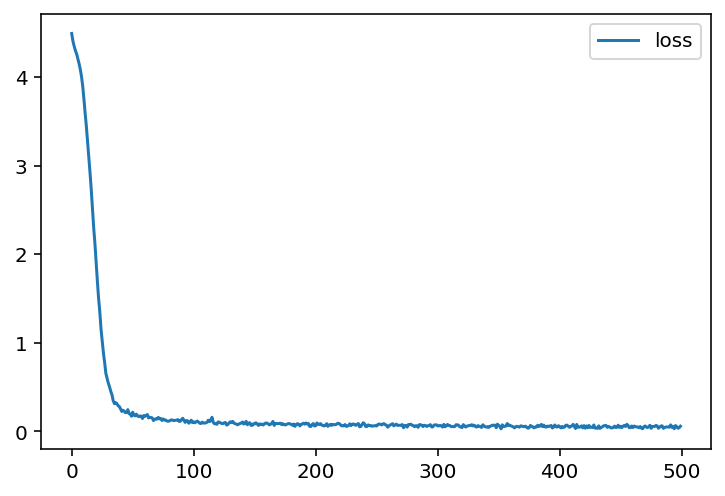

In [8]:
modelLoss = pd.DataFrame(rnnModel.history.history)
modelLoss.plot()

# Music Generation

After the weights are re-loaded into the model, five sequences of 100 numbers, each representing a 100-note sequence, are randomly drawn to be the input data for model prediction. 

In [9]:
SEQSIZE = 100

# Set up prediction input by mapping notes to integers.
inputNotes = []

for i in range(0, len(notes) - SEQSIZE):
    batchInput = processedNotes[i: i+SEQSIZE]
    inputNotes.append([dictRef[n] for n in batchInput])

# reshape input and normalize
batchNum = len(inputNotes)    
inputNotes = np.reshape(inputNotes, (batchNum, SEQSIZE, 1)) / float(alphabetSize)

# create model using weight.
rnnModel2 = createRNNModel(inputNotes, alphabetSize)
rnnModel2.load_weights('ChopinNocturnesLSTMx2.hdf5')

# inputs: 5 random sequences
patterns = []
for i in range(0, 5):
    startNote = np.random.randint(0, len(inputNotes)-1)
    patterns.append(list(inputNotes[startNote]))
    
dictRefReverse = dict((num, pitch) for num, pitch in enumerate(pitches))

5 predictions are made based on the 5 randomly selected input sequences. Each input is first reshaped and normalized before fed into the model. The prediction output is then converted to a note, and is used to generate the next note as part of the input sequence.

In [10]:
from copy import deepcopy
songs = [[], [], [], [], []]

# predict, generate output notes.
# Generate 5 songs, each song has 800 notes.
for j in range(5):
    pat = patterns[j]
    for i in range(800):
        # reshape input and predict
        predIn = np.reshape(pat, (1, len(pat), 1)) / float(alphabetSize)
        prediction = rnnModel2.predict(predIn, verbose=0)
        
        # Convert prediction back to notes
        index = np.argmax(prediction)
        prediction = dictRefReverse[index]
        
        # append to output, and use the new note for further generation.
        songs[j].append(prediction)
        pat.append(index)
        pat = pat[1: len(pat)]
    print('{} song created.'.format(j+1))

1 song created.
2 song created.
3 song created.
4 song created.
5 song created.


The prediction outputs, each from a sequence of notes, are converted back to a stream of MIDI data. 

In [11]:
def generateMidi(outputNotes, fileName):
    offset = 0
    midiOutput = []

    for notePat in outputNotes:

        # It is a chord.
        if ('.' in notePat) or notePat.isdigit():

                # Split to notes
                notes_in_chord = notePat.split('.')
                notes = []

                # chord as notes
                for eachNote in notes_in_chord:
                    new_note = note.Note(int(eachNote))
                    new_note.storedInstrument = instrument.Piano()
                    notes.append(new_note)

                # Convert to midi chord and store
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                midiOutput.append(new_chord)

        # pattern is a note
        else:
            # Convert to midi note and store
            new_note = note.Note(notePat)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            midiOutput.append(new_note)

        # increase offset to make sure notes do not stack
        offset += 0.5

    # Convert to midi stream
    midiOutput = stream.Stream(midiOutput)
    midiOutput.write('midi', fp=fileName)
    
for num, song in enumerate(songs):
    generateMidi(song, 'ChopinNocturnesGenerated_{}.mid'.format(num))

In [12]:
# Listen to the midi music, uncomment the file wish to listen.
# ps = Parser("ChopinValseGenerated_0.mid")
# ps = Parser("ChopinValseGenerated_1.mid")
# ps = Parser("ChopinValseGenerated_2.mid")
# ps = Parser("ChopinValseGenerated_3.mid")
# ps = Parser("ChopinValseGenerated_4.mid")
# ps = Parser("ChopinNocturnesGenerated_0.mid")
# ps = Parser("ChopinNocturnesGenerated_1.mid")
# ps = Parser("ChopinNocturnesGenerated_2.mid")
# ps = Parser("ChopinNocturnesGenerated_3.mid")
# ps = Parser("ChopinNocturnesGenerated_4.mid")

# play_notes(*ps.parse(), np.sin)

# Conclusion

Music generation is a new emerging field with recent advance in deep learning. As a crossroad of technology and art, it extends the ability of artists and brings new elements of style and tempo into music creation. In this music generation project, an LSTM-based RNN model is designed, implemented and trained with a set of 10 Chopin's Valse, and separately, a set of 8 Chopin's Nocturnes. While the generated music pieces are definitely of no match to Frédéric Chopin's original pieces, it provides an insight to the ability of deep learning in art generation, and has proven that music pieces generated by deep learning models are non-trivial and possess a considerable degree of artistic values.

# Acknowledgement

This notebook is partially based on the [instructions](https://github.com/shubham3121/music-generation-using-rnn/blob/master/Jazz%20Music%20Sampling%20.ipynb) given by Shubham Gupta. His effort and guidance is greatly appreciated.